# Initial Model

#### Import libraries and modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,accuracy_score, recall_score, roc_auc_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

#### Import dataMinMaxScaler

In [2]:
data = pd.read_csv('../data/clean_data.csv')

In [3]:
data.head(3)

,file_path,file_name,label,shape,0,1,2,3,4,5,...,95042,95043,95044,95045,95046,95047,95048,95049,95050,95051
0,../data/Images\Im001_ACRIMA.jpg,Im001_ACRIMA.jpg,0,"(178, 178, 3)",162,115,50,163,115,51,...,34,167,72,34,168,71,33,163,67,28
1,../data/Images\Im002_ACRIMA.jpg,Im002_ACRIMA.jpg,0,"(178, 178, 3)",144,108,56,145,109,57,...,25,145,75,26,145,75,26,146,76,27
2,../data/Images\Im003_ACRIMA.jpg,Im003_ACRIMA.jpg,0,"(178, 178, 3)",254,155,26,254,156,27,...,51,220,146,51,220,146,52,219,146,52


#### Define X and y for model

In [4]:
X = data.drop(columns=['file_path', 'file_name', 'label', 'shape'])
y = data['label']

In [5]:
# scale X data to be between 0 and 1
X = X.astype('float32')/255

In [6]:
# convert X into a numpy array where each element 
# is a figure that has the dimensions (178, 178, 3)

image_vectors = np.array(X) # each element is a vector of pixel values

X_array = np.array([row.reshape(178, 178, 3) for row in image_vectors])

X_array.shape # needs to be (705, 178, 178, 3)
              # (number of images, (pixel xy dimensions), RGB)

(705, 178, 178, 3)

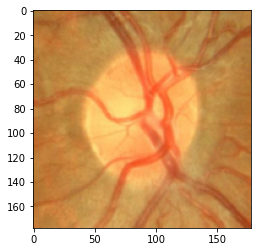

In [7]:
# Check to make sure image is not distorted
plt.imshow(X_array[0]);

In [8]:
# split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_array, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

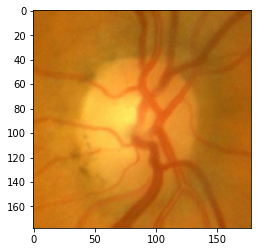

In [9]:
# checking again to make sure images are intact
plt.imshow(X_train[0]);

In [10]:
y_test

105    0
499    1
49     0
610    1
484    1
      ..
362    1
321    1
459    1
87     0
357    1
Name: label, Length: 141, dtype: int64

#### Define Model

In [11]:
cnn = Sequential()

# convolution layer 1
cnn.add(Conv2D(filters=16,
              kernel_size=(3, 3),
              activation='relu',
              input_shape=(178, 178, 3)
              ))
# pooling layer 1
cnn.add(MaxPooling2D(pool_size=(2, 2)))

#flatten layer
cnn.add(Flatten())

#dense layers
cnn.add(Dense(units=128, activation='relu'))

#output layer
cnn.add(Dense(units=1, activation='sigmoid'))

# early stopping
early_stop = EarlyStopping(patience=5)

# Compile model
cnn.compile(loss='bce', 
            optimizer='adam', 
            metrics=['accuracy'])

# Fit model on training data
history = cnn.fit(X_train, y_train,
               batch_size=256,
               epochs=20,
               validation_data=(X_test, y_test),
               callbacks=[early_stop])

Epoch 1/20
3/3 [==============================] - 7s 800ms/step - loss: 15.1472 - accuracy: 0.5089 - val_loss: 1.3984 - val_accuracy: 0.6950
Epoch 2/20
3/3 [==============================] - 2s 675ms/step - loss: 1.9591 - accuracy: 0.6738 - val_loss: 3.0372 - val_accuracy: 0.6738
Epoch 3/20
3/3 [==============================] - 2s 652ms/step - loss: 1.6555 - accuracy: 0.7589 - val_loss: 1.4791 - val_accuracy: 0.7730
Epoch 4/20
3/3 [==============================] - 2s 659ms/step - loss: 1.2814 - accuracy: 0.8014 - val_loss: 1.6170 - val_accuracy: 0.7730
Epoch 5/20
3/3 [==============================] - 2s 646ms/step - loss: 1.1179 - accuracy: 0.8209 - val_loss: 1.6795 - val_accuracy: 0.7518
Epoch 6/20
3/3 [==============================] - 2s 660ms/step - loss: 1.2043 - accuracy: 0.8174 - val_loss: 1.1261 - val_accuracy: 0.8085
Epoch 7/20
3/3 [==============================] - 2s 648ms/step - loss: 0.8702 - accuracy: 0.8564 - val_loss: 1.5318 - val_accuracy: 0.7730
Epoch 8/20
3/3 [===

In [12]:
# uncomment below to save model to directory
# cnn.save('../models/model_01')

In [13]:
preds = cnn.predict(X_test)

In [14]:
y_pred = [0 if p<0.5 else 1 for p in preds]

In [15]:
recall_score(y_test, y_pred)

0.9240506329113924

In [16]:
accuracy_score(y_test, y_pred)

0.8865248226950354

In [17]:
roc_auc_score(y_test, y_pred)

0.8813801551653737

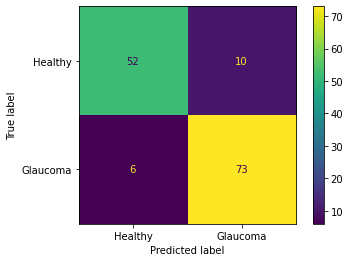

In [18]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                       display_labels=['Healthy', 'Glaucoma']);

In [85]:
predictions_df = pd.DataFrame(y_test)
predictions_df['preds'] = preds

In [86]:
predictions_df['label'].replace({1:'Glaucoma', 0:'Healthy'}, inplace=True)

In [87]:
predictions_df.to_csv('../data/test_predictions.csv', index=False)

In [67]:
import seaborn as sns

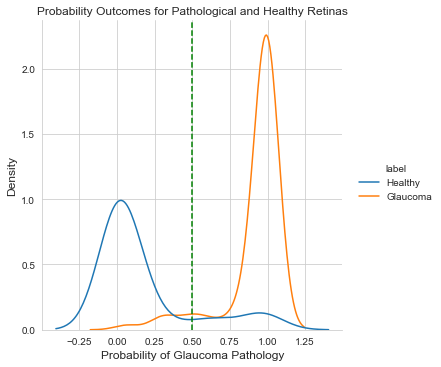

In [89]:
predictions_df = pd.read_csv('../data/test_predictions.csv')

sns.set_style('whitegrid')
sns.displot(data=predictions_df, x='preds', hue='label', kind='kde', height=5, );
plt.axvline(0.5, color='green', linestyle='--')
plt.title('Probability Outcomes for Pathological and Healthy Retinas');
plt.xlabel('Probability of Glaucoma Pathology', size=12)
plt.ylabel('Density', size=12);

# uncomment below to save figure
# plt.savefig('../figures/prob_distribution.png', bbox_inches='tight', dpi=300)